In [3]:
# Functions
# %run data_prep_fns/general_scale.py

# Multiple Outputs per cell
%config interactive_shell.ast_node_interactivity='all'

# Read in test datasets
import pickle
import os
os.chdir('C:/Users/WulfN/Python Projects/time_series_model_comparison')

# Energy data
with open('datasets/energy_dt.pickle', 'rb') as file:
    energy_dt = pickle.load(file)  

# GLobal Population data
with open('datasets/glob_pop.pickle', 'rb') as file_2:
    glob_pop_dt = pickle.load(file_2)

### Testing / Validation Split

In [26]:

# from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split datasets into testing and validation

# Energy data
x_energy = energy_dt.drop(columns = ['total_Wh'])
x_energy_sc = MinMaxScaler().fit_transform(x_energy)
y_energy = energy_dt['total_Wh']
# y_energy_sc = MinMaxScaler().transform(y_energy) # transform so as not to introduce bias from training set from fit() function the testing set
### Test how scaling or NOT scaling y affects the model ###

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_energy_sc, y_energy, test_size = .2, shuffle = False)

# Global Population data
x_glob_pop = glob_pop_dt.drop(columns = ['Population'])
x_glob_pop_sc = MinMaxScaler().fit_transform(x_glob_pop)
y_glob_pop = glob_pop_dt['Population']
# y_glob_pop_sc = MinMaxScaler().transform(y_glob_pop)

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_glob_pop_sc, y_glob_pop, test_size = .2, shuffle = False)


In [ ]:
### Building familiarity with keras and LSTM params

import tensorflow as tf
import keras

tf.random.set_seed(4)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=3, 
                                            min_delta=1,
                                            restore_best_weights=True,
                                            start_from_epoch=5) 

lstm_1 = tf.keras.Sequential() 
lstm_1.add(tf.keras.layers.LSTM(52, activation='relu', 
                                input_shape=(window_size, x_train_1.shape[1]))) 

lstm_1.add(tf.keras.layers.Dense(1)) 
lstm_1.compile(loss='mse', 
               optimizer='adam') 

lstm_1.fit(x=ts_train_windows, # ts_test_windows
           shuffle=False,
           epochs=50,
           callbacks = [callback])


In [35]:
import pandas as pd

# remove first 50 min of actuals since x values are used for prediction
y_actuals = y_test_1[(window_size-1):]
#len(y_test_1.index)

y_hat = pd.DataFrame(lstm_1.predict(ts_test_windows), index = y_actuals.index)
y_hat['predicted_Wh'] = y_hat[0]
y_hat = y_hat.drop(columns = 0)
y_hat

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,predicted_Wh
date,
2016-04-30 09:10:00,59.209778
2016-04-30 09:20:00,60.852684
2016-04-30 09:30:00,61.848660
2016-04-30 09:40:00,62.177410
2016-04-30 09:50:00,61.679867
...,...
2016-05-27 17:20:00,310.848358
2016-05-27 17:30:00,308.837891
2016-05-27 17:40:00,310.877777


In [ ]:
# Test how different window sizes affect model prediction accuracy
window_size = 6 # 6, 24, 72, 144
ts_train_windows = timeseries_dataset_from_array(data=x_train_1, targets=y_train_1, sequence_length=window_size) 
ts_test_windows = timeseries_dataset_from_array(data=x_test_1, targets=y_test_1, sequence_length=window_size)

In [61]:
# Try 1 with generateTrain set

import tensorflow as tf
import keras
import keras_tuner as kt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array


# https://keras.io/guides/keras_tuner/getting_started/

def lstm_model_build(hp):
    
    # Reproducible Results for Param Testing
    tf.random.set_seed(4)

    model_type = hp.Choice("model_type", [#"base", "base_dropout", 
                                          "twostack_dropout"]) # "stacked", "stacked_dropout"

    # Perhaps include data window size variations too

    if model_type == 'base':
        lstm_1 = tf.keras.Sequential() 
        lstm_1.add(tf.keras.layers.LSTM(
            hp.Choice('units', [128, 182]), 
            activation='relu',
            input_shape=(window_size, x_train_1.shape[1]))) 
        lstm_1.add(tf.keras.layers.Dense(1))

    elif model_type == 'base_dropout':
        lstm_1 = tf.keras.Sequential() 
        lstm_1.add(tf.keras.layers.LSTM(
            hp.Choice('units', [128, 182]), 
            activation='relu', 
            input_shape=(window_size, x_train_1.shape[1]))) 
        lstm_1.add(tf.keras.layers.Dropout(.2)) 
        lstm_1.add(tf.keras.layers.Dense(1))

    elif model_type == 'twostack_dropout':
        lstm_1 = tf.keras.Sequential() 
        lstm_1.add(tf.keras.layers.LSTM(
            hp.Choice('units', [128, 182]), 
            activation='relu', 
            input_shape=(window_size, x_train_1.shape[1])),
            return_sequences=True)
        lstm_1.add(tf.keras.layers.LSTM(
            hp.Choice('units', [26, 52, 64, 128, 182]), 
            activation='relu')) 
        lstm_1.add(tf.keras.layers.Dropout(.2)) 
        lstm_1.add(tf.keras.layers.Dense(1))

    lstm_1.compile(loss='mse', optimizer='adam')
        # Learning rate?   
    return lstm_1

tuner = kt.GridSearch(
    hypermodel=lstm_model_build,
    objective=kt.Objective('loss', direction = 'min'),
    # allow_new_entries
    # logger
    executions_per_trial=5,
    seed=89,
    directory='keras_tuner_dir', 
    project_name='lstm_1',
    overwrite=True
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, 
                                            min_delta = .001,
                                            restore_best_weights=True,
                                            start_from_epoch=5) 

# Perform hyperparameter search
tuner.search(
    x=ts_train_windows, 
    # should require a y set as well, right? 
    callbacks=[callback]
)



c:\Users\WulfN\Python Projects\virtual_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TypeError: Sequential.add() got an unexpected keyword argument 'return_sequences'

In [59]:
# Rank of tested models with lowest loss listed first
tuner.results_summary()


Results summary
Results in keras_tuner_dir\lstm_1
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0001 summary
Hyperparameters:
model_type: base
units: 182
Score: 13844.6900390625

Trial 0003 summary
Hyperparameters:
model_type: base_dropout
units: 182
Score: 13941.5560546875

Trial 0000 summary
Hyperparameters:
model_type: base
units: 128
Score: 14257.693359375

Trial 0002 summary
Hyperparameters:
model_type: base_dropout
units: 128
Score: 14427.690234375

Trial 0004 summary
Hyperparameters:
model_type: stacked_dropout
units: 128
Traceback (most recent call last):
  File "c:\Users\WulfN\Python Projects\virtual_env\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\WulfN\Python Projects\virtual_env\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_

In [ ]:
# Graph model with the lowest loss

### Convert output to correct format for graphing
import pandas as pd

# remove first 50 min of actuals since x values are used for prediction
y_actuals = y_test_1[(window_size-1):]
#len(y_test_1.index)

y_hat = pd.DataFrame(lstm_1.predict(ts_test_windows), index = y_actuals.index)
y_hat['predicted_Wh'] = y_hat[0]
y_hat = y_hat.drop(columns = 0)
y_hat

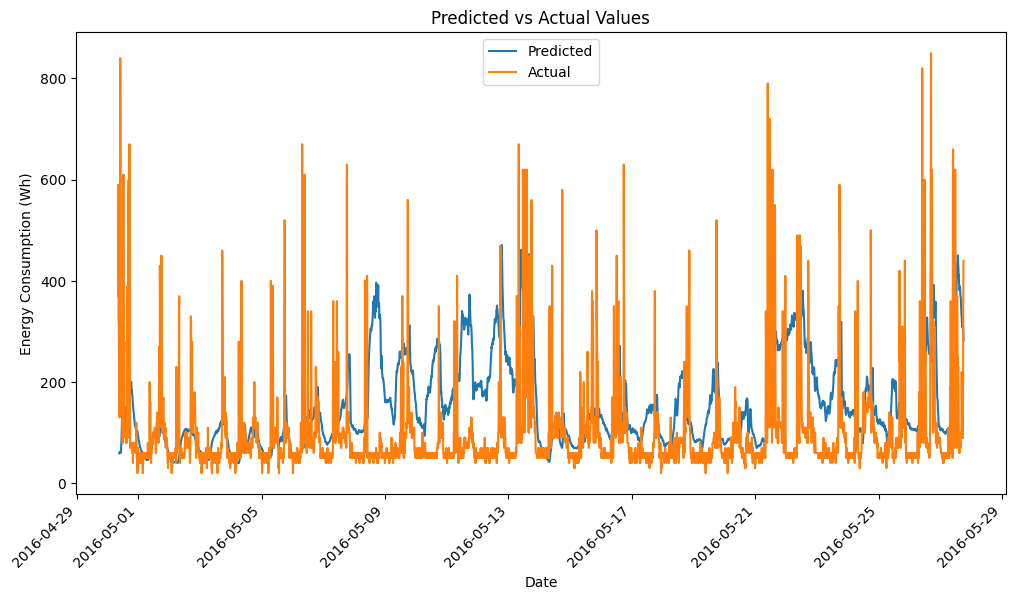

In [46]:
import seaborn as sns

# compare predictions to actuals
import matplotlib.pyplot as plt

# plt.plot(y_hat['predicted_Wh'], label = 'Predictions') 
# plt.plot(y_test_1, label = 'Actuals')   
# plt.legend()
# plt.axes(rotation = 20, ha = 'right')
# plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))
sns.lineplot(data=y_hat['predicted_Wh'], label='Predicted')
sns.lineplot(data=y_test_1, label='Actual')
plt.xticks(rotation=45, ha='right')
plt.title('Predicted vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.show()


In [212]:
import tensorflow as tf
import keras
import keras_tuner as kt
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

tf.random.set_seed(4) # maybe this needs to be within the function

param_space = {
    'model_type': ['base', 'base_dropout'],
    'units': [16, 26],
    'activation': ['relu', 'sigmoid'],
}

keras.callbacks.EarlyStopping(monitor='loss', patience=3)
                              
def lstm_model_build(hp):
    # Perhaps include data window size variations too

    model_type = model_type

    if model_type == 'base':
        lstm_1 = tf.keras.Sequential() 
        lstm_1.add(tf.keras.layers.LSTM(
            units=units, # , 32, 52, 64, 128
            activation=activation,
            input_shape=(window_size, x_train_1.shape[1]))) 
        lstm_1.add(tf.keras.layers.Dense(1))

    elif model_type == 'base_dropout':
        lstm_1 = tf.keras.Sequential() 
        lstm_1.add(tf.keras.layers.LSTM(
            units=units, # , 32, 52, 64, 128
            activation=activation,
            input_shape=(window_size, x_train_1.shape[1]))) 
        lstm_1.add(tf.keras.layers.Dropout(.2)) 
        lstm_1.add(tf.keras.layers.Dense(1))

    lstm_1.compile(loss='mse', optimizer='adam')
        # Learning rate? 

    # Currently, only 1 epoch is run, need callback within this function in order to ensure early stopping occurs    
    return lstm_1

lstm_model = KerasClassifier(build_fn=lstm_model_build, epochs=50)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
grid = GridSearchCV(lstm_model, param_space, cv=None, n_jobs=-1)

grid.fit(ts_train_windows, 
         #ts_test_windows,# y?,
         callbacks = [callback])

TypeError: Singleton array array(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 26), dtype=tf.float64, name=None), TensorSpec(shape=(None, 26), dtype=tf.float64, name=None))>,
      dtype=object) cannot be considered a valid collection.

In [205]:
dir(grid_search)

NameError: name 'grid_search' is not defined

In [ ]:
# compare predictions to actuals
import matplotlib.pyplot as plt

plt.plot(lstm_1.predict(generateTest), label = 'Predictions') # these need to be rescaled
plt.plot(y_test_1, label = 'Actuals')   
plt.legend()
plt.show()


In [ ]:
# compare predictions to actuals
import matplotlib.pyplot as plt

plt.plot(lstm_1.predict(generateTest), label = 'Predictions') # these need to be rescaled
plt.plot(y_test_1, label = 'Actuals')   
plt.legend()
plt.show()
